In [ ]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install tensorboard==2.13.0 \
#     tensorflow==2.13.0 \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     tqdm==4.65.0 \
#     scipy==1.11.1 \
#     scikit-learn==1.3.0 \
#     numpy==1.24.3 \
#     Pillow==10.0.0

In [ ]:
import os
import numpy as np
import polars as pl
from tqdm import tqdm

from typing import List

import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing import normalize

from PIL import Image
import requests
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorboard.plugins import projector

movies_df = pl.from_pandas(pd.read_parquet('imdb_movies.parquet'))
movies_df

title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
str,str,str,str,str,str,list[str],str,f64,f64,list[str],str,list[str],list[str],list[str]
"""tt0111161""","""https://m.medi…","""Movie""","""Побег из Шоуше…","""The Shawshank …","""Over the cours…","[""Drama""]","""1994-10-14""",2.755277e6,9.3,"[""prison"", ""based on the works of stephen king"", … ""voice over narration""]","""It is no wonde…","[""Tim Robbins"", ""Morgan Freeman"", ""Bob Gunton""]","[""Frank Darabont""]","[""Stephen King"", ""Frank Darabont""]"
"""tt0068646""","""https://m.medi…","""Movie""","""Крестный отец""","""The Godfather""","""Don Vito Corle…","[""Crime"", ""Drama""]","""1972-03-24""",1.917037e6,9.2,"[""mafia"", ""patriarch"", … ""rise to power""]","""I love this mo…","[""Marlon Brando"", ""Al Pacino"", ""James Caan""]","[""Francis Ford Coppola""]","[""Mario Puzo"", ""Francis Ford Coppola""]"
"""tt0468569""","""https://m.medi…","""Movie""","""Тёмный рыцарь""","""The Dark Knigh…","""When the menac…","[""Action"", ""Crime"", ""Drama""]","""2008-08-14""",2.728169e6,9.0,"[""dc comics"", ""psychopath"", … ""clown""]","""If someone els…","[""Christian Bale"", ""Heath Ledger"", ""Aaron Eckhart""]","[""Christopher Nolan""]","[""Jonathan Nolan"", ""Christopher Nolan"", ""David S. Goyer""]"
"""tt0050083""","""https://m.medi…","""Movie""","""12 разгневанны…","""12 Angry Men""","""The jury in a …","[""Crime"", ""Drama""]","""1961-11-13""",816234.0,9.0,"[""jury"", ""dialogue driven"", … ""jury room""]","""&apos;12 Angry…","[""Henry Fonda"", ""Lee J. Cobb"", ""Martin Balsam""]","[""Sidney Lumet""]","[""Reginald Rose""]"
"""tt0071562""","""https://m.medi…","""Movie""","""Крестный отец …","""The Godfather …","""The early life…","[""Crime"", ""Drama""]","""1974-12-18""",1.305122e6,9.0,"[""revenge"", ""1950s"", … ""lake tahoe nevada""]","""The original G…","[""Al Pacino"", ""Robert De Niro"", ""Robert Duvall""]","[""Francis Ford Coppola""]","[""Francis Ford Coppola"", ""Mario Puzo""]"
"""tt0108052""","""https://m.medi…","""Movie""","""Список Шиндлер…","""Schindler&apos…","""In German-occu…","[""Biography"", ""Drama"", ""History""]","""1994-05-21""",1.388917e6,9.0,"[""holocaust"", ""nazi"", … ""german""]","""This Movie was…","[""Liam Neeson"", ""Ralph Fiennes"", ""Ben Kingsley""]","[""Steven Spielberg""]","[""Thomas Keneally"", ""Steven Zaillian""]"
"""tt0167260""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""Gandalf and Ar…","[""Action"", ""Adventure"", ""Drama""]","""2004-01-22""",1.892435e6,9.0,"[""journey"", ""orc"", … ""ring""]","""Wonderful on e…","[""Elijah Wood"", ""Viggo Mortensen"", ""Ian McKellen""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"
"""tt0110912""","""https://m.medi…","""Movie""","""Криминальное ч…","""Pulp Fiction""","""The lives of t…","[""Crime"", ""Drama""]","""1995-09-29""",2.115956e6,8.9,"[""nonlinear timeline"", ""overdose"", … ""drug dealing""]","""I can only spe…","[""John Travolta"", ""Uma Thurman"", ""Samuel L. Jackson""]","[""Quentin Tarantino""]","[""Quentin Tarantino"", ""Roger Avary""]"
"""tt0120737""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""A meek Hobbit …","[""Action"", ""Adventure"", ""Drama""]","""2002-03-01""",1.920951e6,8.8,"[""ring"", ""quest"", … ""elf""]","""Here is one fi…","[""Elijah Wood"", ""Ian McKellen"", ""Orlando Bloom""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"


## Описание данных

Для решения задачи вам доступны следующие данные из файла `imdb_movies.parquet`

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| title_id        | str                  | IMDb идентификатор                       |
| poster_url      | str                  | Ссылка на постер                         |
| type            | str                  | Тип тайтла: Movie или TVSeries           |
| name            | str                  | Название тайтла на русском               |
| original_name   | str                  | Оригинальное название тайтла             |
| description     | str                  | Описание тайтла с IMDb                   |
| genre           | list[str]            | Список жанров                            |
| date            | str                  | Дата выпуска тайтла                      |
| rating_count    | int                  | Количество отзывов для тайтла            |
| rating_value    | float                | Средний рейтинг тайтла                   |
| keywords        | list[str]            | Ключевые слова для тайтла (сгенерированы пользователями IMDb) |
| featured_review | str                  | Избранная рецензия для тайтла            |
| stars           | list[str]            | Список ключевых актеров                  |
| directors       | list[str]            | Список режиссеров                        |
| creators        | list[str]            | Список создателей                        |

## Оценивание

В качестве метрики качества используется hitrate@10, которую можно интерпретировать как **вероятность, что хотя бы один из топ-10 рекомендуемых объектов является релевантным**. Чтобы получить максимальный балл, достаточно добиться hitrate@10 = 0.3

В качестве `y_relevant` используются тайтлы, которые встречаются вместе в оценках пользователей

In [ ]:
TOP_K = 10
SUBMISSION_PATH = 'submission.parquet'
RELEVANT_TITLES_PATH = 'relevant_titles_subsample.parquet'


def hitrate(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_preds[:k])) > 0)

# код для подсчета метрики качества
def print_score():
    hitrate_list = []
    user_preds = {title_id: recs for title_id, recs in pl.read_parquet(SUBMISSION_PATH).rows()}
    for title_id, relevant_items in pl.read_parquet(RELEVANT_TITLES_PATH).rows():
        recommended_titles = user_preds.get(title_id, [])[:TOP_K]
        hitrate_list.append(hitrate(relevant_items, recommended_titles))

    mean_hitrate = float(np.mean(hitrate_list))
    print(f'HITRATE@10 = {mean_hitrate}')

## Построим случайные рекомендации

In [ ]:
def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    # берем с запасом, чтобы не рекомендовать тайтл для самого себя
    random_movies = np.random.choice(movies_df['title_id'].unique().to_list(), TOP_K + 1)
    return [title_id for title_id in random_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission.parquet')

print_score()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 9798/9798 [00:13<00:00, 706.56it/s]


HITRATE@10 = 0.038


## Построим рекомендации самых популярных

In [ ]:
# берем с запасом, чтобы не рекомендовать тайтл для самого себя
top_movies = movies_df.sort('rating_value', descending=True)['title_id'][:(TOP_K + 1)].to_list()

def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    return [title_id for title_id in top_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission.parquet')

print_score()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9798/9798 [00:00<00:00, 352118.85it/s]

HITRATE@10 = 0.08


## Формат разреженных матриц

In [ ]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
sp.csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

## Построим рекомендации на основе пересечения ключевых слов

In [ ]:
movies_df['keywords'].explode().unique()

keywords
str
"""lunch"""
"""horseback ridi…"
"""actor reprises…"
"""forbidden love…"
"""motel"""
"""press conferen…"
"""abused woman"""
"""identity swap"""
"""stranded on an…"


In [ ]:
mapping = {
    k: v
    for v, k in enumerate(movies_df['keywords'].explode().unique().to_list())
}
print(f'{len(mapping)}')

15052


In [ ]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []
for row_ind, keywords in enumerate(movies_df['keywords']):
    col_inds = [mapping[x] for x in keywords]
    rows.extend([row_ind] * len(col_inds))
    values.extend([1] * len(col_inds))
    cols.extend(col_inds)

In [ ]:
sparse_data = sp.csr_matrix((values, (rows, cols)))
sparse_data = normalize(sparse_data, norm='l2', axis=1)
display(sparse_data)

similarities = (sparse_data @ sparse_data.T).A
# уберем 1 по диагонали, чтобы не рекомендовать тайтл для самого себя
similarities -= np.eye(len(similarities), dtype=similarities.dtype)
display(similarities.shape)

<9798x15052 sparse matrix of type '<class 'numpy.float64'>'
	with 45762 stored elements in Compressed Sparse Row format>

(9798, 9798)

In [ ]:
def get_recommendations(title_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[title_ind])[::-1][:k]
    return movies_df[nearest_inds]['title_id'].to_list()

TOP_K = 10

submission = []
for title_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][title_ind]
    recommended_titles = get_recommendations(title_ind, TOP_K)
    submission.append((title_id, recommended_titles))

submission = pl.DataFrame(submission, schema=('title_id', 'recs'))
submission.write_parquet('submission.parquet')
display(submission.head())

print_score()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9798/9798 [00:02<00:00, 4098.83it/s]


title_id,recs
str,list[str]
"""tt0111161""","[""tt6589464"", ""tt7667038"", … ""tt0072684""]"
"""tt0068646""","[""tt11497716"", ""tt7661390"", … ""tt9820352""]"
"""tt0468569""","[""tt7302054"", ""tt0078346"", … ""tt2193021""]"
"""tt0050083""","[""tt7949212"", ""tt0050051"", … ""tt8975028""]"
"""tt0071562""","[""tt4882708"", ""tt11151696"", … ""tt4264096""]"


HITRATE@10 = 0.101


## Сохраним эмбеддинги для просмотра в tensorboard

In [ ]:
!rm -rf ./embs

In [ ]:
log_dir = './embs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for title_name in movies_df[:1_000]['name']:
        f.write(f'{title_name}\n')

weights = tf.Variable(sparse_data[:1_000].A)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
!tensorboard --logdir embs --bind_all

TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Визуализация рекомендаций

In [ ]:
def get_recommendations_inds(item_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[item_ind])[::-1][:k]
    return nearest_inds

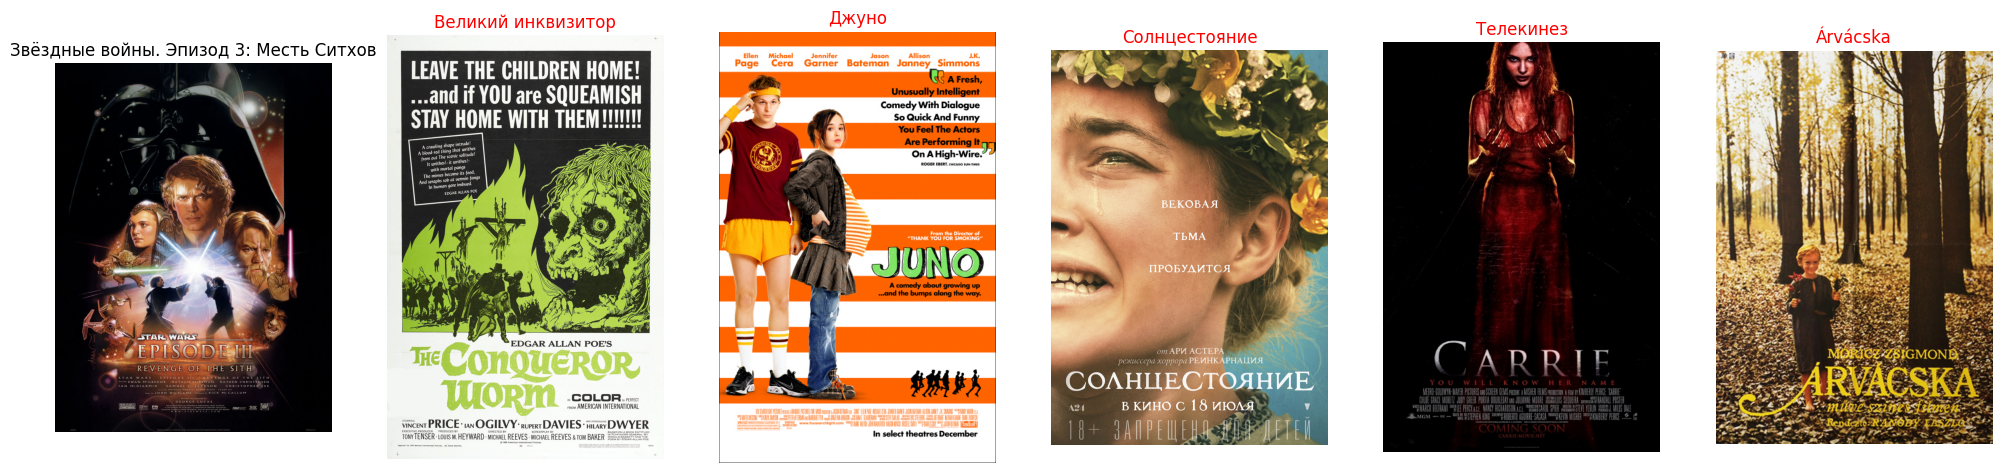

In [ ]:
k = 5
fig, axs = plt.subplots(1, k + 1, figsize=(25, 10))

title_id = 'tt0121766'
title_ind = movies_df['title_id'].to_list().index(title_id)

relevant_titles = (
    pl.read_parquet(RELEVANT_TITLES_PATH)
    .filter(pl.col('title_id') == title_id)
)['relevant_titles'].explode().to_list()

# отрисовываем запрашиваемый тайтл
url = movies_df['poster_url'][title_ind]
im = Image.open(requests.get(url, stream=True).raw)
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title(movies_df['name'][title_ind])

# строим рекомендации
nearest_inds = get_recommendations_inds(title_ind, k)
recs_posters = movies_df[nearest_inds]['poster_url']
recs_names = movies_df[nearest_inds]['name']
recs_title_ids = movies_df[nearest_inds]['title_id']

# визуализируем рекомендации
for i, (url, name) in enumerate(zip(recs_posters, recs_names)):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[1 + i].imshow(im)
    axs[1 + i].axis('off')
    axs[1 + i].set_title(name, color=('g' if recs_title_ids[i] in relevant_titles else 'r'))

plt.show();

Идеи для улучшения:
- попробуйте различные метрики дистанции между эмбеддингами
- используйте больше признаков для построения разреженной матрицы
- попробуйте использовать description и featured_review для извлечения признаков (например, tf-idf/w2v/openAI эмбеддинги)